## Training a BERT Model

Importing the required libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split

In [2]:
import json
import pandas as pd

# Loading the file for Model Training
file_path = "z639_assignment1_training.json"

with open(file_path, "r", encoding="utf-8") as file:
    data = [json.loads(line) for line in file]

# Converting to Pandas DataFrame
df = pd.DataFrame(data)

# Displaying the structure of the dataset
df.head()

,text,parent_comment,article_title,article_url,platform,platform_id,composite_toxic
0,"WTF, y'all never made MRE fart balloons in the...",None,Triangular UFO hovers over California military...,https://www.dailymail.co.uk/news/article-12112...,reddit,jlcm021,"[[False, 74], [True, 323], [False, 1028], [Fal..."
1,No apologies !! McCall has balls ! Ccp is not...,None,China sentences elderly US citizen to life in ...,https://www.cnn.com/2023/05/15/china/china-jai...,youtube,Ugws8gNW7eJyE9VHeM14AaABAg,"[[False, 216], [False, 197], [False, 1039], [F..."
2,What ever you need to tell yourself to sleep a...,I wonder how many undercover agents will be go...,Jan. 6 defendant who put foot on desk in Pelos...,https://www.cbsnews.com/news/richard-barnett-j...,youtube,UgxHlqwNcVssLHUr4yF4AaABAg.9q7kOunSlu-9q7lHH4he6S,"[[True, 192], [True, 193], [True, 260], [True,..."
3,@exZACKly @CBSNews Fuck off Nazi,@NCmylo @CBSNews Lol. Stop choosing to be an ...,19-year-old Missouri man arrested in U-Haul cr...,https://www.cbsnews.com/news/u-haul-crash-lafa...,twitter,1661025155047637000,"[[True, 92], [False, 218], [True, 69], [True, ..."
4,Texas is a republican sponsored killing ground...,None,At Least 8 Killed After Driver Plows Car Into ...,https://www.nytimes.com/2023/05/07/us/car-pede...,youtube,UgwpAfn9RIV0cHfhp4R4AaABAg,"[[False, 56], [True, 207], [False, 218], [Fals..."


Extracting the label with majority voting

In [3]:
# Function to determine if a given comment is toxic or not based on majority voting
def determine_toxicity(composite_toxic):
    toxicity_votes = [entry[0] for entry in composite_toxic]  # Extracting True/False votes
    return sum(toxicity_votes) > (len(toxicity_votes) / 2)  # Returns the label with Majority wins

# Applying the function to extract the final label
df["is_toxic"] = df["composite_toxic"].apply(determine_toxicity)

# Displaying only the necessary columns
df_cleaned = df[["text", "platform_id","is_toxic"]]
df_cleaned.head()

,text,platform_id,is_toxic
0,"WTF, y'all never made MRE fart balloons in the...",jlcm021,False
1,No apologies !! McCall has balls ! Ccp is not...,Ugws8gNW7eJyE9VHeM14AaABAg,False
2,What ever you need to tell yourself to sleep a...,UgxHlqwNcVssLHUr4yF4AaABAg.9q7kOunSlu-9q7lHH4he6S,True
3,@exZACKly @CBSNews Fuck off Nazi,1661025155047637000,True
4,Texas is a republican sponsored killing ground...,UgwpAfn9RIV0cHfhp4R4AaABAg,False


In [5]:
from huggingface_hub import notebook_login

notebook_login()

## Tokenization

In [8]:
from transformers import BertTokenizer

# Loading pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the entire dataset
encoded_data = tokenizer(
    df_cleaned["text"].tolist(),   # Tokenizes all the comments
    padding="max_length",          # Ensuring it has uniform input size
    truncation=True,               # Truncates longer comments
    max_length=128,                # Maximum token length
    return_tensors="pt"            # Returns PyTorch tensors
)

# Extracting tokenized inputs
input_ids = encoded_data["input_ids"]
attention_mask = encoded_data["attention_mask"]

# Checking tokenization output for first few samples
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([4000, 128])
torch.Size([4000, 128])


## Converting Tokenized Data into PyTorch Dataset

In [9]:
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# Defining a PyTorch Dataset Class
class ToxicityDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
        }

# Ensuring labels are in tensor format
labels = torch.tensor(df_cleaned["is_toxic"].values, dtype=torch.long)

# Splitting tokenized data
train_ids, val_ids, train_mask, val_mask, train_labels, val_labels = train_test_split(
    input_ids, attention_mask, labels, test_size=0.2, random_state=42
)


print("Train Labels Shape:", train_labels.shape)
print("Validation Labels Shape:", val_labels.shape)

# Defining Dataset Objects
train_dataset = ToxicityDataset(train_ids, train_mask, train_labels)
val_dataset = ToxicityDataset(val_ids, val_mask, val_labels)

Train Labels Shape: torch.Size([3200])
Validation Labels Shape: torch.Size([800])


## Creating DataLoaders

In [10]:
from torch.utils.data import DataLoader

# batch size recommended for BERT
batch_size = 16

# Creating DataLoader for Training
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Creating DataLoader for Validation
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Checking Batch Structure
batch = next(iter(train_dataloader))
print(batch["input_ids"].shape)

torch.Size([16, 128])


## Loading the trained BERT model

In [25]:
from transformers import BertConfig, BertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Modifying dropout to prevent overfitting
config = BertConfig.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    hidden_dropout_prob=0.4,
    attention_probs_dropout_prob=0.4
)

#Loading model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.4, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Defining Training arguments

In [36]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to="none",
    learning_rate=1e-5,  #Lower LR for fine-tuning
    lr_scheduler_type="cosine",  #Using cosine decay for better generalization
    load_best_model_at_end=True,  #Automatically loads the best model
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=2,  # Keeps only the best 2 models
    save_steps=100
)

In [37]:
import torch.nn as nn

# Computing class weights to Handle imbalance
toxic_count = df_cleaned["is_toxic"].sum()
non_toxic_count = len(df_cleaned) - toxic_count
class_weights = torch.tensor([1.0 / non_toxic_count, 1.0 / toxic_count], dtype=torch.float32).to(device)

# Defining weighted loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

In [38]:
from transformers import Trainer, EarlyStoppingCallback

# Defining Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").to(torch.long)  # Ensuring labels are long type
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Early stopping if no improvement
)


In [35]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.680400,0.690936
2,0.696400,0.685974
3,0.623200,0.591754
4,0.595100,0.590408


TrainOutput(global_step=800, training_loss=0.6563996279239654, metrics={'train_runtime': 497.4601, 'train_samples_per_second': 25.731, 'train_steps_per_second': 1.608, 'total_flos': 841955377152000.0, 'train_loss': 0.6563996279239654, 'epoch': 4.0})

The loss is decreasing significantly which indicates that the model is learning well.

## Model Evaluation

In [52]:
import torch
from torch.utils.data import DataLoader
import numpy as np

# Storing predictions and actual labels
all_preds = []
all_labels = []

# Evaluation mode
model.eval()

with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Get model output
        outputs = model(input_ids, attention_mask=attention_mask)

        # Removing Adaptive Threshold
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        threshold = 0.55  # Fixed threshold instead of dynamic adjustment
        preds = (probs[:, 1] > threshold).long()

        # Store results
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert results to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ✅ Computing Metrics
from sklearn.metrics import accuracy_score, classification_report

print("Model Evaluation:")
print("Model Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds))




Model Evaluation:
Model Accuracy: 0.74875
              precision    recall  f1-score   support

           0       0.90      0.75      0.81       590
           1       0.51      0.76      0.61       210

    accuracy                           0.75       800
   macro avg       0.71      0.75      0.71       800
weighted avg       0.80      0.75      0.76       800



The overall Model Accuracy is almost 75% which is decent. The classification report shows that the model is better at detecting toxic comments than avoiding false alarms. High Precision for Non-Toxic shows Very few non-toxic comments are incorrectly flagged as toxic.
High Recall for Toxic shows most toxic comments are detected correctly.

Visualizing the confusion Matrix

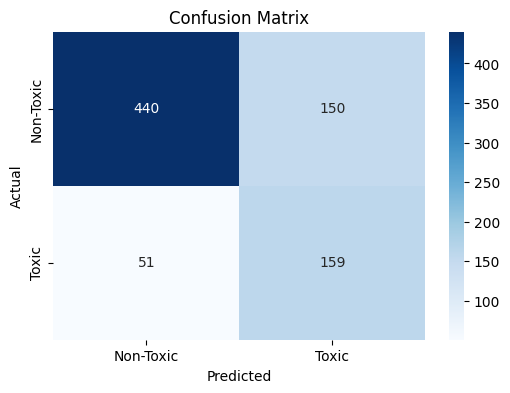

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Toxic", "Toxic"], yticklabels=["Non-Toxic", "Toxic"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

440 correct non-toxic classifications (True Negatives)

159 correctly detected toxic comments (True Positives)

150 false positives (non-toxic comments wrongly marked toxic)

51 false negatives (missed toxic comments)



In [57]:
# Saving model and tokenizer
model.save_pretrained("bert_toxic_classifier")
tokenizer.save_pretrained("bert_toxic_classifier")

print("Model saved successfully!")

Model saved successfully!


## Predictions on Test Dataset

In [58]:
import json
import pandas as pd

# Loading Test Dataset
test_file_path = "z639_assignment1_test.json"

with open(test_file_path, "r", encoding="utf-8") as file:
    test_data = [json.loads(line) for line in file]

df_test = pd.DataFrame(test_data)
test_texts = df_test["text"].tolist()

## Tokenization of Test dataset

In [59]:
#Tokenize Test Dataset
encoded_test = tokenizer(
    test_texts,
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

test_input_ids = encoded_test["input_ids"]
test_attention_mask = encoded_test["attention_mask"]

In [62]:
def predict_toxicity(input_ids, attention_mask):
    inputs = {
        "input_ids": input_ids.to(device),
        "attention_mask": attention_mask.to(device)
    }
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return True if torch.argmax(probs) == 1 else False

#Prediction for All Test Comments
df_test["prediction"] = [
    predict_toxicity(test_input_ids[i].unsqueeze(0), test_attention_mask[i].unsqueeze(0))
    for i in range(len(test_texts))
]

# Converting Boolean Predictions to Lowercase Strings
df_test["prediction"] = df_test["prediction"].astype(str).str.lower()

# Displaying Predictions
print(df_test[["platform_id", "prediction"]].head(5))

                                         platform_id prediction
0  UgxjV6HRpnD6FUmw8aV4AaABAg.9pH-CgX5yEH9pH7BMIfAz5       true
1                                1657052099564150784       true
2                                1662672469205958656      false
3                                1656508255454019587      false
4                                            jk1pm1m      false


In [61]:
# Saving the prediction file
Prediction = df_test[["platform_id", "prediction"]]
Prediction.to_csv("Prediction.csv", index=False)

## Trainin a SVM Model

Importing libraries

In [63]:
import pandas as pd
import numpy as np
import json
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [64]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [78]:
# Load JSON training dataset
train_file_path = "z639_assignment1_training.json"
with open(train_file_path, "r") as file:
    train_data = [json.loads(line) for line in file]

# Convert to DataFrame
df_train = pd.DataFrame(train_data)

# Check first few rows
df_train.head()

,text,parent_comment,article_title,article_url,platform,platform_id,composite_toxic
0,"WTF, y'all never made MRE fart balloons in the...",None,Triangular UFO hovers over California military...,https://www.dailymail.co.uk/news/article-12112...,reddit,jlcm021,"[[False, 74], [True, 323], [False, 1028], [Fal..."
1,No apologies !! McCall has balls ! Ccp is not...,None,China sentences elderly US citizen to life in ...,https://www.cnn.com/2023/05/15/china/china-jai...,youtube,Ugws8gNW7eJyE9VHeM14AaABAg,"[[False, 216], [False, 197], [False, 1039], [F..."
2,What ever you need to tell yourself to sleep a...,I wonder how many undercover agents will be go...,Jan. 6 defendant who put foot on desk in Pelos...,https://www.cbsnews.com/news/richard-barnett-j...,youtube,UgxHlqwNcVssLHUr4yF4AaABAg.9q7kOunSlu-9q7lHH4he6S,"[[True, 192], [True, 193], [True, 260], [True,..."
3,@exZACKly @CBSNews Fuck off Nazi,@NCmylo @CBSNews Lol. Stop choosing to be an ...,19-year-old Missouri man arrested in U-Haul cr...,https://www.cbsnews.com/news/u-haul-crash-lafa...,twitter,1661025155047637000,"[[True, 92], [False, 218], [True, 69], [True, ..."
4,Texas is a republican sponsored killing ground...,None,At Least 8 Killed After Driver Plows Car Into ...,https://www.nytimes.com/2023/05/07/us/car-pede...,youtube,UgwpAfn9RIV0cHfhp4R4AaABAg,"[[False, 56], [True, 207], [False, 218], [Fals..."


In [79]:
import re
import pandas as pd
from nltk.corpus import stopwords

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters and numbers
    text = " ".join([word for word in text.split() if word not in stopwords.words("english")])  # Remove stopwords
    return text

# Apply text cleaning
df_train["clean_text"] = df_train["text"].fillna("").apply(clean_text)

# Function to get majority vote on toxicity (returns True/False instead of 0/1)
def get_majority_label(toxic_list):
    return sum(label[0] for label in toxic_list) > len(toxic_list) / 2  # Returns True or False

# Apply majority vote to get final label
df_train["is_toxic"] = df_train["composite_toxic"].apply(get_majority_label).astype(bool)  # Convert to bool explicitly

# Drop unnecessary columns
df_train = df_train[["clean_text", "is_toxic"]]

# Display first few rows
print(df_train.head())


                                          clean_text  is_toxic
0  wtf yall never made mre fart balloons stumps f...     False
1       apologies mccall balls ccp nothing full crap     False
2          ever need tell sleep night fucking retard      True
3                         exzackly cbsnews fuck nazi      True
4  texas republican sponsored killing ground teac...     False


In [76]:
# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters and numbers
    text = " ".join([word for word in text.split() if word not in stopwords.words("english")])  # Remove stopwords
    return text

# Apply cleaning
df_train["clean_text"] = df_train["text"].apply(clean_text)

# Function to get majority vote on toxicity
def get_majority_label(toxic_list):
    return int(sum(label[0] for label in toxic_list) > len(toxic_list) / 2)  # If >2 votes for True, classify as toxic

# Apply majority vote to get final label
df_train["is_toxic"] = df_train["composite_toxic"].apply(get_majority_label)

# Drop unnecessary columns
df_train = df_train[["clean_text", "is_toxic"]]
df_train.head()


,clean_text,is_toxic
0,wtf yall never made mre fart balloons stumps f...,0
1,apologies mccall balls ccp nothing full crap,0
2,ever need tell sleep night fucking retard,1
3,exzackly cbsnews fuck nazi,1
4,texas republican sponsored killing ground teac...,0


In [80]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(df_train["clean_text"])
y_train = df_train["is_toxic"]

# Convert to array
X_train = X_train_tfidf.toarray()

In [81]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [83]:
# Define SVM model
svm_model = SVC(kernel="linear")

# Perform 5-Fold Cross-Validation
cv_scores = cross_val_score(svm_model, X_train_final, y_train_final, cv=5, scoring="accuracy")

# Print results
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

# Train final SVM model
svm_model.fit(X_train_final, y_train_final)

Cross-Validation Accuracy Scores: [0.74375   0.7453125 0.7640625 0.7609375 0.7515625]
Mean CV Accuracy: 0.7531


SVC(kernel='linear')

In [85]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on training data (for evaluation)
y_train_pred = svm_model.predict(X_train_final)

# Model evaluation
accuracy = accuracy_score(y_train_final, y_train_pred)
classification_rep = classification_report(y_train_final, y_train_pred)
conf_matrix = confusion_matrix(y_train_final, y_train_pred)

print("Model Evaluation")
print(f"Model Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

Model Evaluation
Model Accuracy: 0.8866
Classification Report:
               precision    recall  f1-score   support

       False       0.88      0.98      0.93      2384
        True       0.93      0.60      0.73       816

    accuracy                           0.89      3200
   macro avg       0.90      0.79      0.83      3200
weighted avg       0.89      0.89      0.88      3200

Confusion Matrix:
 [[2348   36]
 [ 327  489]]


In [33]:
# Predict on validation set
y_val_pred = svm_model.predict(X_val)

# Evaluate performance
print("🚀 SVM Model Evaluation:")
print("✅ Accuracy:", accuracy_score(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

🚀 SVM Model Evaluation:
✅ Accuracy: 0.75375
Confusion Matrix:
 [[554  36]
 [161  49]]
Classification Report:
               precision    recall  f1-score   support

       false       0.77      0.94      0.85       590
        true       0.58      0.23      0.33       210

    accuracy                           0.75       800
   macro avg       0.68      0.59      0.59       800
weighted avg       0.72      0.75      0.71       800



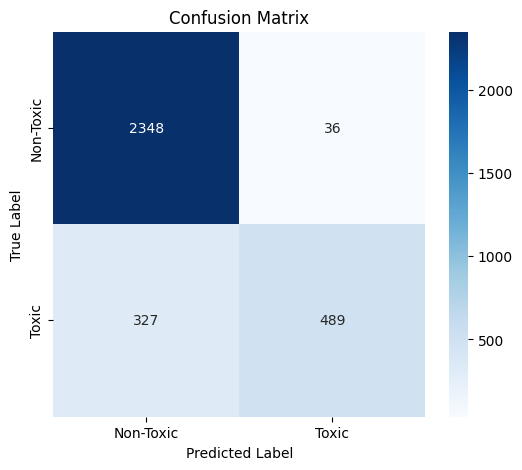

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_train_final, y_train_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Toxic", "Toxic"], yticklabels=["Non-Toxic", "Toxic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [88]:
import json
import pandas as pd

# Load test dataset
test_file_path = "z639_assignment1_test.json"

with open(test_file_path, 'r', encoding='utf-8') as f:
    test_data = [json.loads(line) for line in f]

df_test = pd.DataFrame(test_data)

In [89]:
# Apply text cleaning function (ensure `clean_text` is defined)
df_test["clean_text"] = df_test["text"].fillna("").apply(clean_text)

print("Test dataset loaded and preprocessed.")
print(df_test.head())

Test dataset loaded and preprocessed.
                                                text  \
0                                Ukrainian Bullshit.   
1  @LibDems No one likes you.\nYou denied democra...   
2  @EPurpera @BBCNews POS terrorist dictator Putr...   
3  @howardfineman @darkblue714 Bullshit. CNN set ...   
4  The war will be won by who "wins" the race bet...   

                                      parent_comment  \
0                               Russian   Propaganda   
1                                               None   
2              @BBCNews They should make peace talk.   
3                                               None   
4  What is the pope gonna do? Pray and throw a co...   

                                       article_title  \
0  Kremlin drone: Zelensky denies Ukraine attacke...   
1  UK economy shrank 0.3% in March, ONS figures show   
2  Ukraine war: Kyiv hit by new massive Russian d...   
3  Opinion | Why CNN's Trump town hall was always...   
4  Zelen

In [90]:
# Transform test text using the trained TF-IDF vectorizer
X_test_tfidf = vectorizer.transform(df_test["clean_text"])

print("Test data transformed using TF-IDF.")

Test data transformed using TF-IDF.


In [91]:
# Predict using trained SVM model
test_predictions = svm_model.predict(X_test_tfidf)

# Store predictions in DataFrame (as True/False)
df_test["predicted_toxicity"] = test_predictions

ValueError: cannot use sparse input in 'SVC' trained on dense data